# Momentum Crashes

In [145]:
import pandas as pd
import numpy as np
from numpy import size, log, pi, sum, array, zeros, diag, mat, asarray, sqrt, \
copy
from numpy.linalg import inv
from scipy.optimize import fmin_slsqp
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats,misc
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline
plt.rcParams.update({'font.size': 14})

### 1. Try to write down the logic and intuition described in the paper

**Momentum** refers to the tendency of rising stock prices to rise further and falling stock prices to fall further. If there is a market crash and following that crash, if there is a sudden recovery, V-shaped recovery that is the time during that recovery phase, the "classical" momentum strategy (buy past winners and sell past losers) will fail. 

In normal times the winner portfolio outperforms the loser, but during such a **momentum crash** the loser portfolio massively outperforms the winners. Kent Daniel illustrated this with the fact that over the 3 months between March and May 2009 the winner portfolio rose by only 6.5% but the loser portfolio (or the stocks that had collapsed the hardest in the financial crisis) rose by 156%

Kent Daniel discovered that these momentum crashes are partly forecastable: there is a panic state, the market drops sharply, market volatility is high and there is a market rebounding. These four are warning signals that momentum strategy's not going to work. And we should hedge the momentum portfolio with option-like payoffs of past losers.

### 2. Compare price series of DJTMNMO and MOM for the overlapping interval

**DJTMNMO** (*Dow Jones U.S. Thematic Market Neutral Momentum Index*) index is equal weighted, dollar neutral, sector neutral and is not levered. The Index rebalances monthly by identifying the highest momentum stocks as long positions and lowest momentum stocks as short positions, of approximately equal dollar amounts, within each sector.

**MOM** (*QuantShares U.S. Market Neutral Momentum Fund ETF*) seeks to track, before fees and expenses, the Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index. The Index is equal weighted, dollar neutral, sector neutral and is not levered. The Index rebalances monthly by identifying the highest momentum stocks as long positions and lowest momentum stocks as short positions, of approximately equal dollar amounts, within each sector.

Consider the data for the last 5 years

In [2]:
start_date='2014-12-18'
end_date='2019-12-18'

The DJTMNMO index isn't listed at Yahoo Finace, so we just scraped it from https://seekingalpha.com/

In [ ]:
from bs4 import BeautifulSoup
import csv
csv_fp = open("djtmnmo.csv","w")
csv_writer = csv.writer(csv_fp,delimiter=',')
data = []
with open("Dow Jones US Thematic Market Neutral Momentum Index (DJTMNMO) Historical Prices   Seeking Alpha.htm") as fp:
    soup = BeautifulSoup(fp,features="lxml")
    table = soup.find("table", {"id": "historical-quotes-table"})
    csv_writer.writerow([col.string for col in table.thead.tr if col.string!='Volume'])

    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        csv_writer.writerow([ele.replace(' %','') for ele in cols if ele and ele!='-']) # Get rid of empty values        


In [3]:
mom=yf.download('MOM',start=start_date,end=end_date)['Close']

djmnmo = pd.read_csv("djtmnmo.csv",sep=',', thousands=',',parse_dates=True,index_col='Date')
djtmnmo = djmnmo['Close']

[*********************100%***********************]  1 of 1 completed


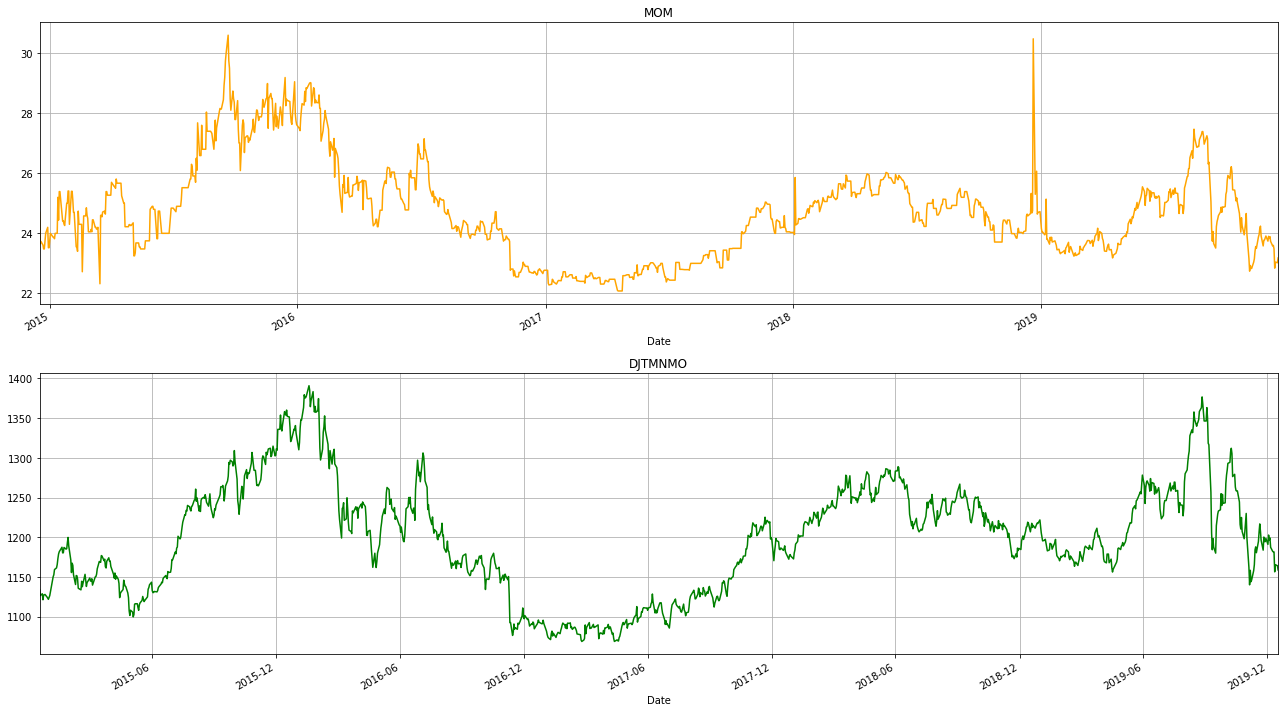

In [4]:
plt.subplot(2,1,1)
mom.plot(figsize=(18,10),color='orange',title='MOM',grid=True)
plt.subplot(2,1,2)
djtmnmo.plot(figsize=(18,10),color='green',title='DJTMNMO',grid=True)
plt.tight_layout()

Pearson’s correlation

In [5]:
mom.corr(djtmnmo)

0.8787633155316751

We can see that DJTMNMO and MOM correlate quite good.

### 3. Try to replicate the price series of DJTMNMO using MTUM and SPY returns

**MTUM** (*iShares MSCI USA Momentum Factor ETF*) seeks to track, before fees and expenses, the MSCI USA Momentum Index. A momentum value is determined for each stock in the MSCI USA Index (about 625 mid and large cap stocks) by combining the stock’s recent 12-month and 6-month local price performance. This momentum value is then risk-adjusted to determine the stock’s momentum score. A fixed number of securities with the highest momentum scores are included in each MSCI Momentum Index, or about 125 stocks. The 125 stocks are weighted by the product of their momentum score and their market cap. The Index is rebalanced semiannually; in addition, ad hoc rebalancing may occur, triggered by spikes in market volatility. 

**SPY** (*SPDR S&P 500 ETF*) seeks to track, before fees and expenses, the S&P 500 Index. The Index is a capitalization-weighted index made up of 500 widely held large-cap U.S. stocks spread out among eleven sectors of the economy using the GCIS sector classification system. It is not the largest 500 companies in the U.S., but rather 500 companies picked by a committee at S&P. These experts consider various factors when determining the 500 stocks that are included in the index, including market size, liquidity and industry grouping.

**DJTMNMO** index measures the performance of an investment strategy utilizing long positions in high momentum companies and short positions in low momentum companies. This is achieved by allocating a long position of 100% in the Dow Jones U.S. High Momentum Index and a short position of -100% in theDow Jones U.S. Low Momentum Index. Momentum is calculated by ranking stocks by their 12-month historical total return, as of the rebalancing referencedate.

1. ***Dow Jones U.S. High Momentum Index***. The index measures the performance of 200 high momentum companies based on their 12-month historical pricereturn.
2. ***Dow Jones U.S. Low Momentum Index***.The index measures the performance of 200 low momentum companies based on their 12-month historical price return.

The index is designed to measure the performance of a long/short  strategy utilizing long positions in high-momentum companies and short positions in low-momentum companies. Momentum is calculated by ranking stocks by their 12-month historical total return, starting one month prior to reconstitution. The index is calculated using long and short indices as its basis. It is designed to be market- and sector-neutral.

In [6]:
mtum = yf.download('MTUM',start=start_date,end=end_date)
spy = yf.download('SPY',start=start_date,end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


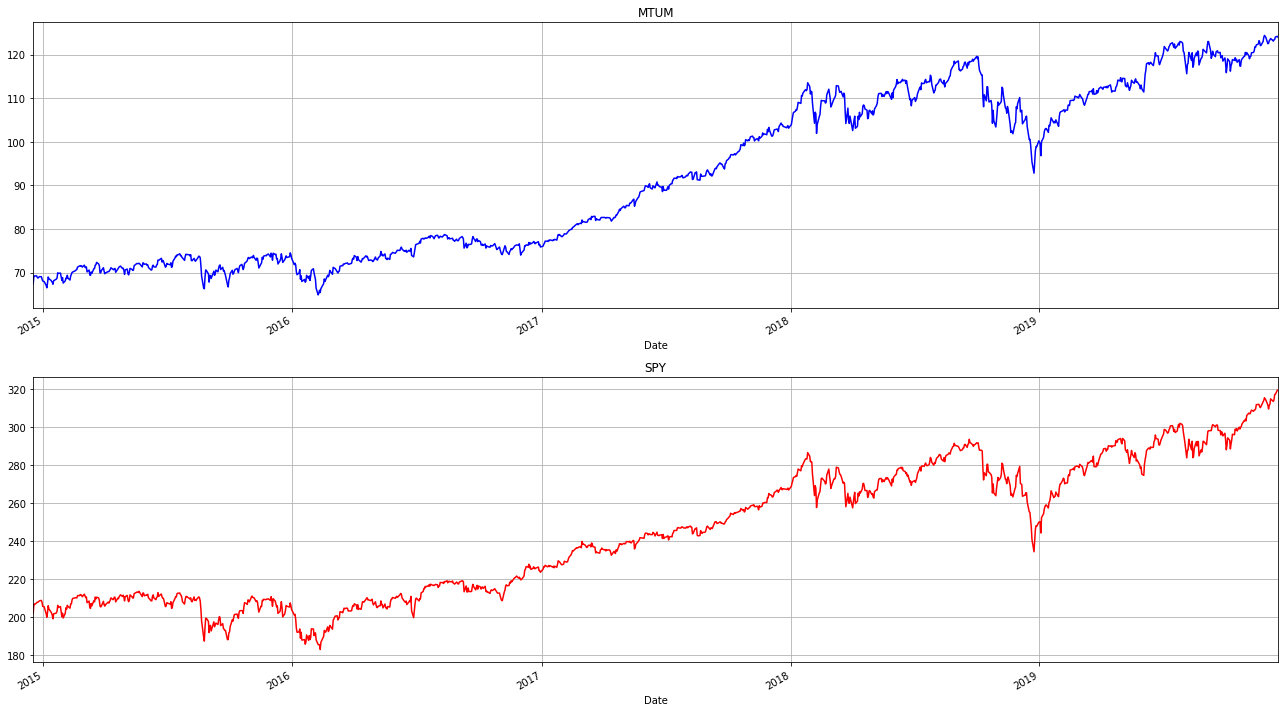

In [7]:
plt.subplot(2,1,1)
mtum['Close'].plot(figsize=(18,10),color='blue',title='MTUM',grid=True)
plt.subplot(2,1,2)
spy['Close'].plot(figsize=(18,10),color='red',title='SPY',grid=True)
plt.tight_layout()

According to the description of the indicies let's try to divide the MTUM value by the SPO value and check out the result.

In [12]:
repl_djtmnmo = mtum['Close']/spy['Close']
repl_djtmnmo.tail()

Date
2019-12-11    0.392469
2019-12-12    0.389462
2019-12-13    0.390930
2019-12-16    0.388764
2019-12-17    0.387959
Name: Close, dtype: float64

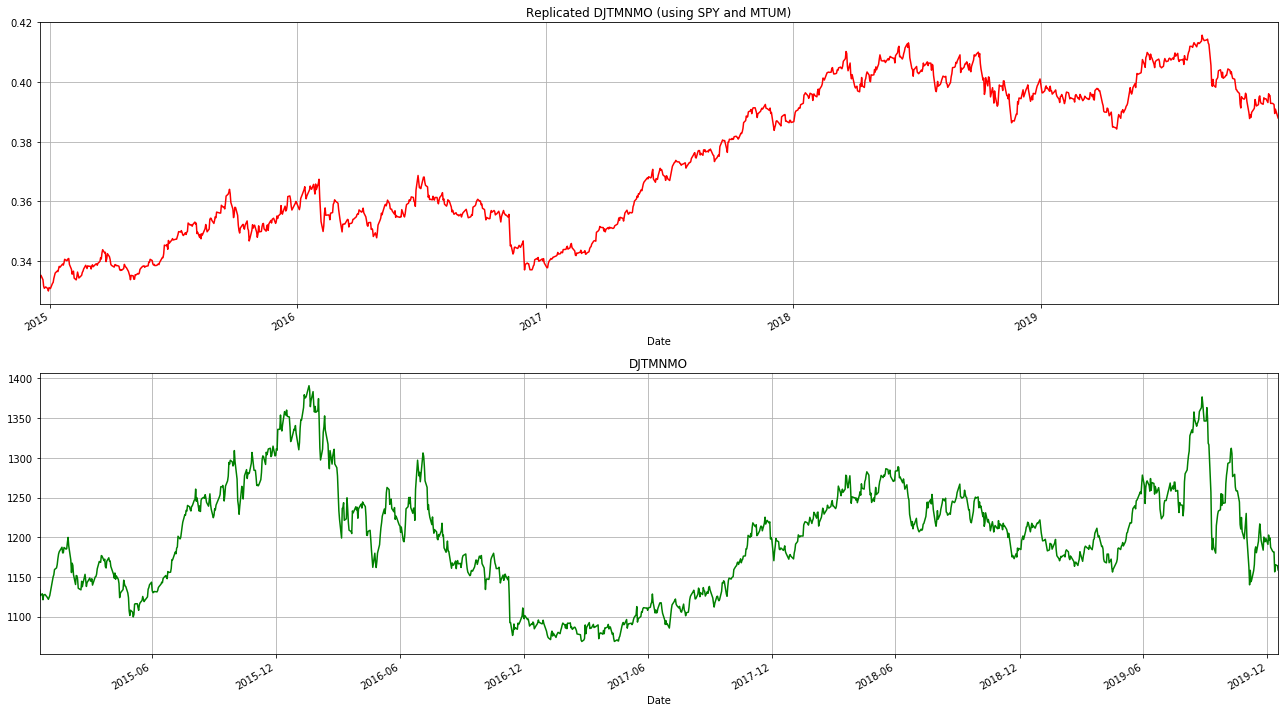

In [13]:
plt.subplot(2,1,1)
repl_djtmnmo.plot(figsize=(18,10),color='red',title='Replicated DJTMNMO (using SPY and MTUM)',grid=True)
plt.subplot(2,1,2)
djtmnmo.plot(figsize=(18,10),color='green',title='DJTMNMO',grid=True)
plt.tight_layout()

In form, the charts are quite similar, but the original chart is more steep. Let's check the correlation coefficient:

In [14]:
repl_djtmnmo.corr(djtmnmo,method='spearman')

0.520314295842351

Correlation is not ideal, though it's ok and we can see the similarity.

### 4. Using insights/ideas from the paper, try to come up with a quantitative strategy which trades momentum factor, while being market neutral (hedged by SPY (ETF). The list of factors to consider VIX,  realized market volatility, seasonality etc.

## Cumulative Return (Momentum) calculations

We downloaded the yearly prices data for the S&P 500 companies. Let's take the lookback period as 12 months, skip the last month as Kent Daniel suggests and calculate the momentum:

### $R(t,T)=\prod\limits _{s=t+1}^{T}(1+R_{S})-1$ 

In [67]:
tickers = pd.read_csv('tickers.csv')
companies=[]
for ind,ticker in tickers.iterrows():
    try:
        company=yf.download(ticker['Symbol'],start=start_date,end=end_date)
        company_month = pd.DataFrame()
        company_month['Return'] = company['Close'].resample('BM').apply(lambda x: x[-1]).pct_change()
        company_month['Return'].fillna(0,inplace=True)
        company_month['Momentum'] = company_month['Return'].rolling(11).apply(lambda x: (np.cumprod(1 + x))[0] - 1,raw=False)
        companies.append([ticker['Name'],ticker['Symbol'],company_month])        
    except:
        pass

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [68]:
with open('tickers.pkl', 'wb') as f:
    pickle.dump(companies, f)

In [73]:
with open('tickers.pkl', 'rb') as f:
    companies = pickle.load(f)

w_l = sorted(companies,key=lambda x:x[2]['Momentum'][-1],reverse=True)
    

In [76]:
print ("Ten winners (highest momentum over last 11 months)")
print ([c[0] for c in w_l[:10]])

Ten winners (highest momentum over last 11 months)
['Coty, Inc', 'Celgene Corp.', 'PG&E Corp.', 'Hanesbrands Inc', 'Motorola Solutions Inc.', 'Mattel Inc.', 'Garmin Ltd.', 'Cadence Design Systems', 'Best Buy Co. Inc.', 'Global Payments Inc.']


In [77]:
print ("Ten losers (lowest momentum over last 11 months)")
print ([c[0] for c in w_l[-10:]])

Ten losers (lowest momentum over last 11 months)
['Western Union Co', 'Ventas Inc', 'The Mosaic Company', 'Vornado Realty Trust', 'Weyerhaeuser Corp.', 'Valero Energy', 'TripAdvisor', 'WestRock Company', 'United Health Group Inc.', 'CenturyLink Inc']


Let's check out the charts of the winners and losers:

In [123]:
start_date = '2019-01-01'
end_date = '2019-12-01'
winners = pd.DataFrame()
for c in w_l[:10]:
    winners[c[1]] = yf.download(c[1],start=start_date,end=end_date)['Close']

losers = pd.DataFrame()
for c in w_l[-10:]:
    losers[c[1]] = yf.download(c[1],start=start_date,end=end_date)['Close']
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

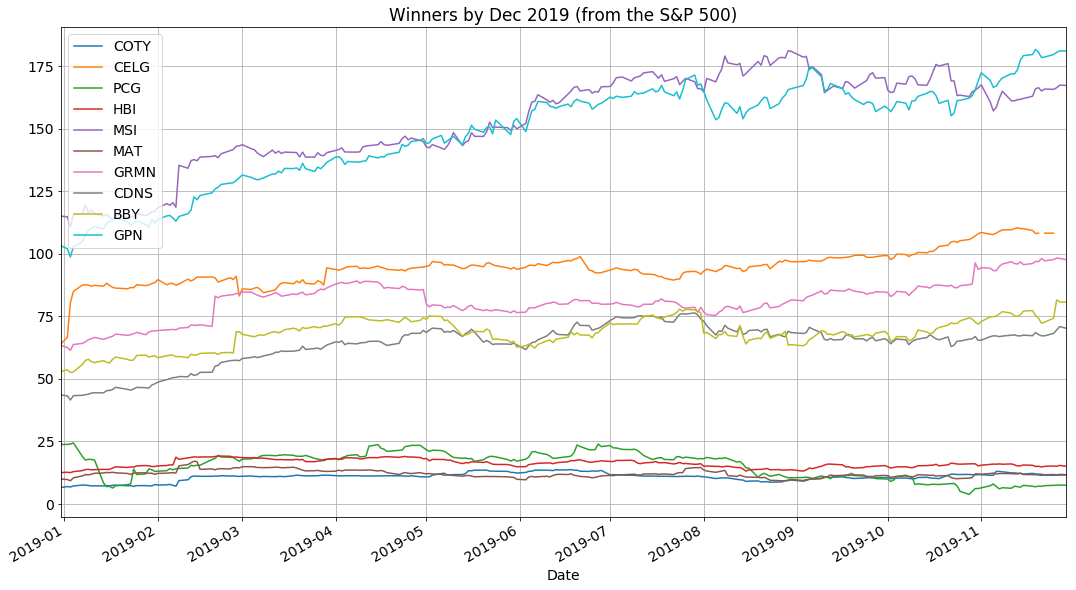

In [124]:
winners.plot(grid=True,title='Winners by Dec 2019 (from the S&P 500)',figsize=(18,10))

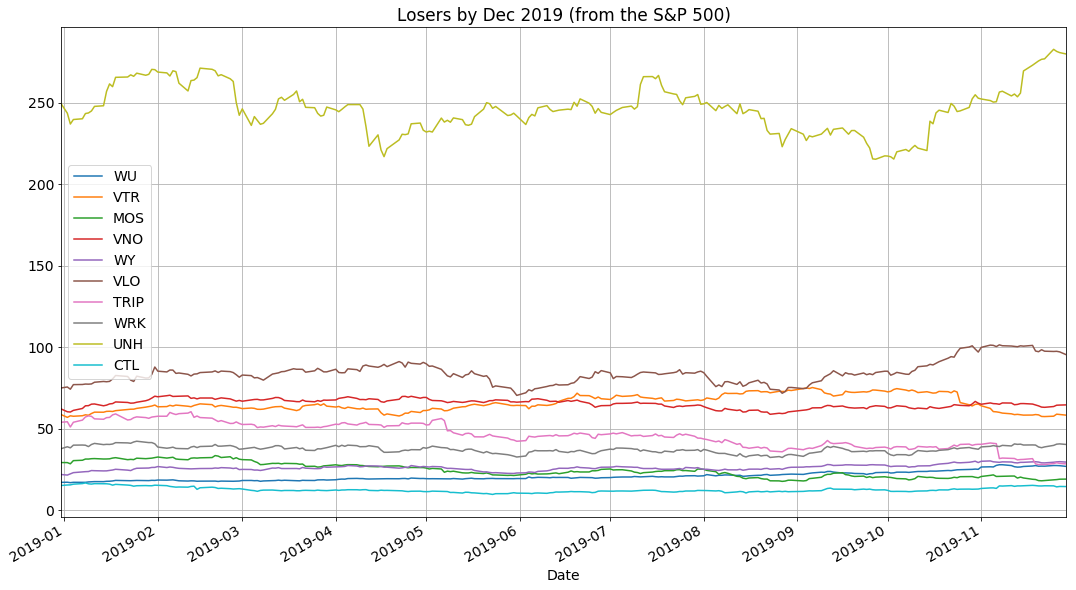

In [125]:
losers.plot(grid=True,title='Losers by Dec 2019 (from the S&P 500)',figsize=(18,10))

### Maximum Sharpe Ratio Strategy

To maximize the in-sample unconditional Sharpe ratio, the optimal weight on the risky asset (WML - Winners minus Losers) at time $t − 1$ is:

### $\omega ^{*}_{t-1}= \left(\dfrac{1}{2\lambda}\right)\dfrac{\mu _{t-1}}{\sigma ^{2} _{t-1}}$

where $\mu _{t-1}\equiv \mathbb{E _{t-1}}[r _{WML,t}]$ is the conditional expected return on the (zero-investment) WML
portfolio over the coming month, $\sigma ^{2}_{t-1}\equiv \mathbb{E _{t-1}}[\left(r^{2} _{WML,t} - \mu _{t-1}\right)^2]$ is the conditional variance
of the WML portfolio return over the coming month, and $\lambda$ is a time-invariant scalar that
controls the unconditional risk and return of the dynamic portfolio

In [126]:
winners_return = winners.pct_change().fillna(0)

COTY     2.470697
CELG     7.063169
PCG     -0.087558
HBI      1.775952
MSI      6.805844
MAT      0.990150
GRMN     7.128894
CDNS     8.137862
BBY      4.241140
GPN     12.772005
dtype: float64

In [139]:
# Equal weights of each asset in the risky part of portfolio
weights = [0.1]*10
risky_ret = (winners_return*weights).sum(axis=1)
risky_mean_var = risky_ret.mean()/risky_ret.var()
# Let's consider lambda=10
_lambda = 10
w_risky = 0.5/_lambda*risky_mean_var
print ('Risky fraction:',round(w_risky,4))
print ('Risk-free fraction:',round(1-w_risky,4))

Risky fraction: 0.4
Risk-free fraction: 0.6


### GJR-GARCH Momentum Portfolio Volatility

In [88]:
def gjr_garch_likelihood(parameters, data, sigma2, out=None):
    ''' Returns negative log-likelihood for GJR-GARCH(1,1,1) model.'''
    mu = parameters[0]
    omega = parameters[1]
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]
    
    T = size(data,0)
    eps = data - mu
    # Data and sigma2 are T by 1 vectors
    for t in range(1,T):
        sigma2[t] = (omega + alpha * eps[t-1]**2 
                     + gamma * eps[t-1]**2 * (eps[t-1]<0) + beta * sigma2[t-1])
    
    logliks = 0.5*(log(2*np.pi) + np.log(sigma2) + eps**2/sigma2)
    loglik = sum(logliks)
    
    if out is None:
        return loglik
    else:
        return loglik, logliks, copy(sigma2)

In [89]:
def gjr_constraint(parameters, data, sigma2, out=None):
    ''' Constraint that alpha+gamma/2+beta<=1'''
    
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]

    return array([1-alpha-gamma/2-beta])

In [90]:
def hessian_2sided(fun, theta, args):
    f = fun(theta, *args)
    h = 1e-5*np.abs(theta)
    thetah = theta + h
    h = thetah - theta
    K = size(theta,0)
    h = np.diag(h)
    
    fp = zeros(K)
    fm = zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        
    fpp = zeros((K,K))
    fmm = zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j],  *args)
            fmm[j,i] = fmm[i,j]
            
    hh = (diag(h))
    hh = hh.reshape((K,1))
    hh = hh @ hh.T
    
    H = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

In [141]:
# Starting values
startingVals = np.array([risky_ret.mean(),
                      risky_ret.var() * .01,
                      .03, .09, .90])

In [146]:
# Estimate parameters
finfo = np.finfo(np.float64)
bounds = [(-10*risky_ret.mean(), 10*risky_ret.mean()),
          (finfo.eps, 2*risky_ret.var() ),
          (0.0,1.0), (0.0,1.0), (0.0,1.0)]
       
T = risky_ret.shape[0]
sigma2 = np.ones(T) * risky_ret.var()
# Pass a NumPy array, not a pandas Series
args = (np.asarray(risky_ret), sigma2)
estimates = fmin_slsqp(gjr_garch_likelihood, startingVals,
                       f_ieqcons=gjr_constraint, bounds = bounds,
                       args = args)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -654.7588446105615
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1


In [147]:
loglik, logliks, sigma2final = gjr_garch_likelihood(estimates, risky_ret,
                                                    sigma2, out=True)

In [149]:
step = 1e-5 * estimates
scores = zeros((T,5))
for i in range(5):
    h = step[i]
    delta = np.zeros(5)
    delta[i] = h
    
    loglik, logliksplus, sigma2 = gjr_garch_likelihood(estimates + delta, \
                               np.asarray(risky_ret), sigma2, out=True)
    loglik, logliksminus, sigma2 = gjr_garch_likelihood(estimates - delta, \
                              np.asarray(risky_ret), sigma2, out=True)                   
               
    scores[:,i] = (logliksplus - logliksminus)/(2*h)

I = (scores.T @ scores)/T

In [150]:
J = hessian_2sided(gjr_garch_likelihood, estimates, args)
J = J/T
Jinv = mat(inv(J))
vcv = Jinv*mat(I)*Jinv/T
vcv = asarray(vcv)

In [151]:
output = np.vstack((estimates,sqrt(diag(vcv)),estimates/sqrt(diag(vcv)))).T    
print('Parameter   Estimate       Std. Err.      T-stat')
param = ['mu','omega','alpha','gamma','beta']
for i in range(len(param)):
    print('{0:<11} {1:>0.6f}        {2:0.6f}    {3: 0.5f}'.format(param[i],
           output[i,0], output[i,1], output[i,2]))

Parameter   Estimate       Std. Err.      T-stat
mu          0.001766        0.001153     1.53153
omega       0.000002        0.000006     0.34334
alpha       0.030000        0.093203     0.32188
gamma       0.090000        0.050012     1.79956
beta        0.900000        0.146073     6.16128


<Figure size 432x288 with 0 Axes>

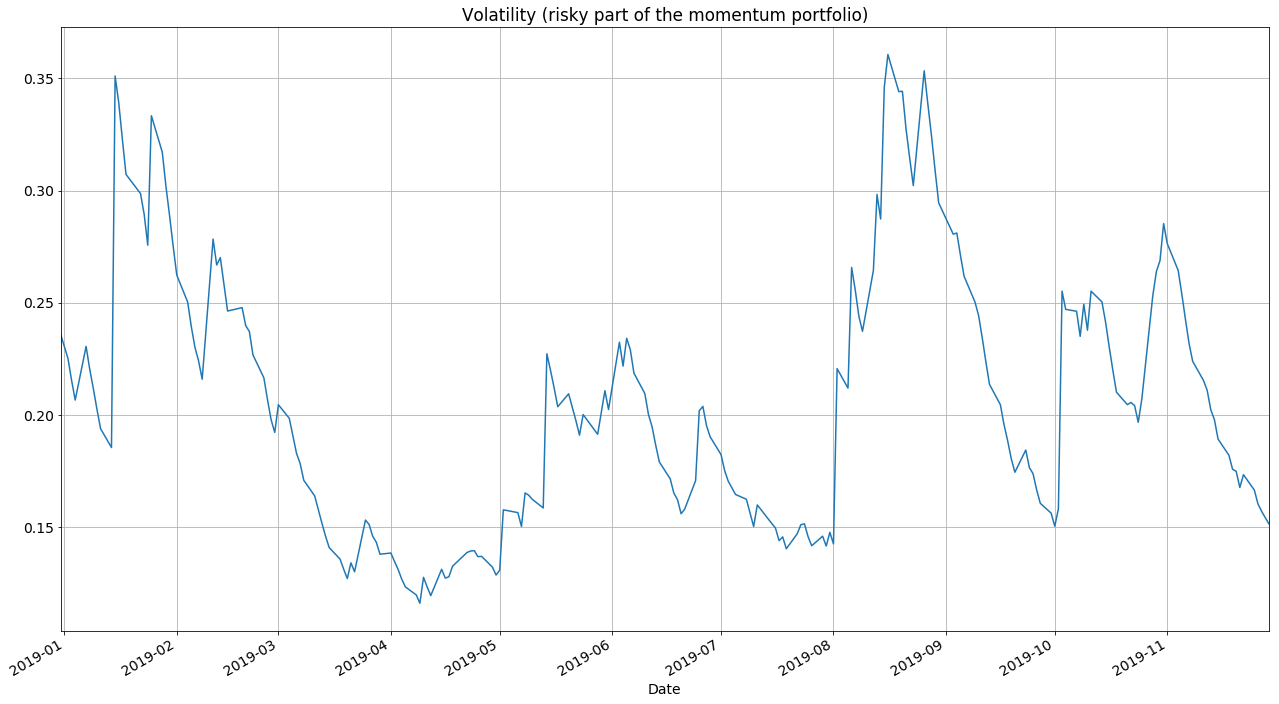

In [178]:
# Produce a plot
dates = risky_ret.index
fig = plt.figure()
volatility = pd.DataFrame(np.sqrt(252 * sigma2), index=dates)
volatility.plot(figsize=(18,10),grid=True,title='Volatility (risky part of the momentum portfolio)',legend=None)
plt.tight_layout()

### Hedging the risks

The **VIX** Index is a calculation designed to produce a measure of constant, 30-day expected volatility of the U.S. stock market, derived from real-time, mid-quote prices of S&P 500® Index (SPXSM) call and put options. On a global basis, it is one of the most recognized measures of volatility -- widely reported by financial media and closely followed by a variety of market participants as a daily market indicator.

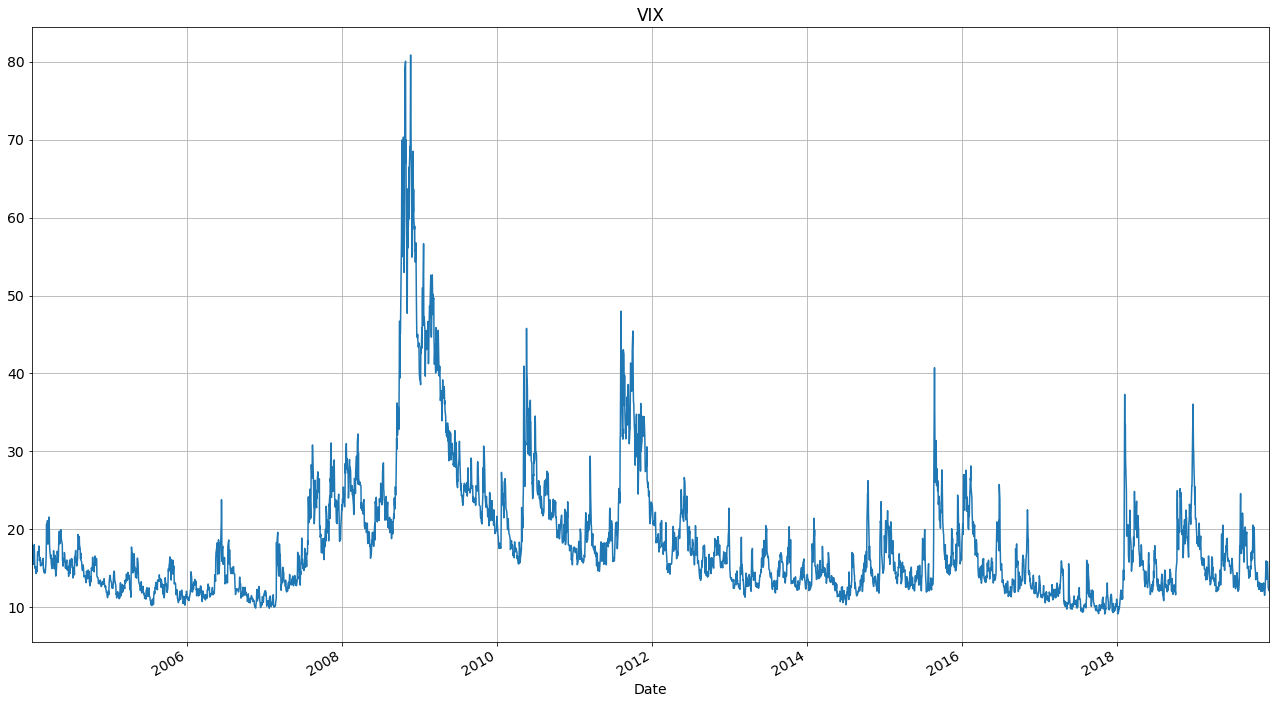

In [181]:
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
vix = pd.read_csv('vixcurrent.csv',parse_dates=['Date'], date_parser=dateparse,index_col='Date')['VIX Close']
vix.plot(figsize=(18,10),grid=True,title='VIX',legend=None)
plt.tight_layout()

The daily return on a variance swap, from day $t−1$ to day $t$:

 Let's calculate the desired hedging trade which will neutralize market exposure of the portfolio using SPY ETF

In [133]:
spy = yf.download('SPY',start = start_date,end = end_date)['Close']
spy_ret = spy.pct_change().fillna(0)

[*********************100%***********************]  1 of 1 completed


In [134]:
(beta, alpha) = stats.linregress(spy_ret.values,
                risky_ret.values)[0:2]
                
print("Portfolio alpha =", round(alpha,5))
print("Portfolio beta =", round(beta, 4))

Portfolio alpha = 0.00068
Portfolio beta = 1.0678


In [135]:
portfolio_value = 1000000
spy_shares = int(round(portfolio_value*beta/spy[-1]))

print ('SPY shares to buy: ',spy_shares)

SPY shares to buy:  3397


### 5. Try to come up with a model which estimates the trade volume of people who track momentum factor

Let's try to find out how it can be determined that the trader uses the momentum factor.

The simplest way is to track the momentum of companies for different periods (week, month, year) and if the company is in the "Winners" or "Losers" list over that period we take into account transactions with this asset and (it's important) with other assets from the top lists at the same time.

In [164]:
w_l = sorted(companies,key=lambda x:x[2]['Momentum'][-1],reverse=True)

print ("Top ten winners (over last 11 months):", [c[0] for c in w_l[:10]])
print ('\n')
print ("Top ten losers (over last 11 months):", [c[0] for c in w_l[-10:]])

Top ten winners (over last 11 months): ['Coty, Inc', 'Celgene Corp.', 'PG&E Corp.', 'Hanesbrands Inc', 'Motorola Solutions Inc.', 'Mattel Inc.', 'Garmin Ltd.', 'Cadence Design Systems', 'Best Buy Co. Inc.', 'Global Payments Inc.']


Top ten losers (over last 11 months): ['Western Union Co', 'Ventas Inc', 'The Mosaic Company', 'Vornado Realty Trust', 'Weyerhaeuser Corp.', 'Valero Energy', 'TripAdvisor', 'WestRock Company', 'United Health Group Inc.', 'CenturyLink Inc']


A more advanced model may include modeling the behavior of a trader during a crash (portfolio reversing etc), during the crisis period and restoring a classical momentum portfolio when the crisis is over.

Also, Machine Learning classification techniques are very suitable here.